In [49]:
#日付
import datetime
#平方根
from math import sqrt
#numpyのインストール
import numpy as np
#pandasのインストール
import pandas as pd
#statsmodelsのインストール
import statsmodels.api as sm
#時系列モデルのインストール
from statsmodels.tsa import stattools as st
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import coint as ct
#scikit-learnのインストール
import sklearn.linear_model as lm
#msnoのインストール
import missingno as msno
#pyplotのインストール
import matplotlib.pyplot as plt
#seabornのインストール
import seaborn as sns
%matplotlib inline
sns.set()
lr = lm.LinearRegression()

In [11]:
w_data = pd.read_csv('data4.csv', index_col='year', parse_dates=True)

In [12]:
w_data = w_data.loc[:'2015-12-01']

In [13]:
x_true_value = w_data.loc['2016-01-01':]

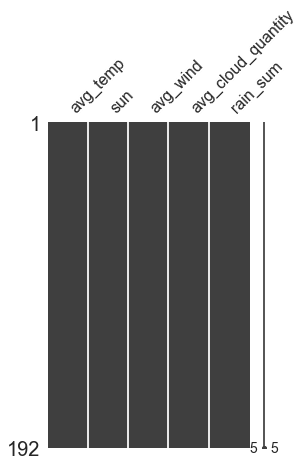

In [14]:
#データ欠損の確認 (欠損なし！)
msno.matrix(df=w_data,figsize=(4,6))

# ADF検定（単位根検定の資料）
## https://www.slideshare.net/teramonagi/r-7066155
## P-values > 0.05 then, 単位根
## wind, cloudが単位根、それ以外が定常性を持つ

In [15]:
#原系列に対するADF検定
print (st.adfuller(w_data['avg_temp'].values.ravel()))
print (st.adfuller(w_data['sun'].values.ravel()))
print (st.adfuller(w_data['avg_wind'].values.ravel()))
print (st.adfuller(w_data['rain_sum'].values.ravel()))
print (st.adfuller(w_data['avg_cloud_quantity'].values.ravel()))

(-3.2900637663836467, 0.015328508913554114, 13, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 560.484979923089)
(-5.616589192480479, 1.170606324354971e-06, 5, 186, {'1%': -3.466005071659723, '5%': -2.8772078537639385, '10%': -2.5751221620996647}, 1800.7981370591356)
(-1.9690874586506262, 0.3002894367029275, 13, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 133.76320669439235)
(-7.969310934484765, 2.8091012202364616e-12, 9, 182, {'1%': -3.4668001583460613, '5%': -2.8775552336674317, '10%': -2.5753075498128246}, 2119.8995652066324)
(-2.8600582212346004, 0.05019373726663235, 12, 179, {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}, 498.0715668537154)


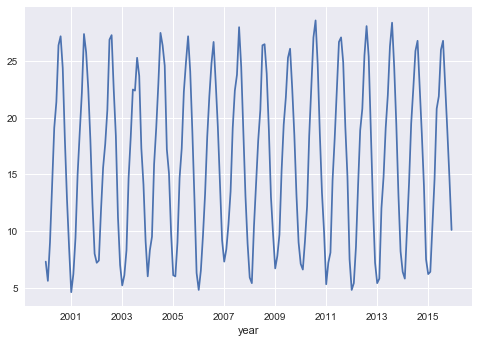

In [496]:
#原系列のplot
w_data['avg_temp'].plot()

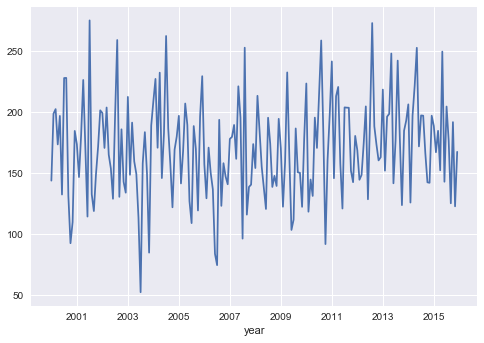

In [497]:
w_data['sun'].plot()

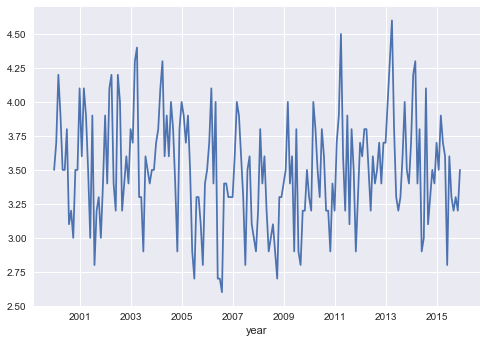

In [498]:
w_data['avg_wind'].plot()

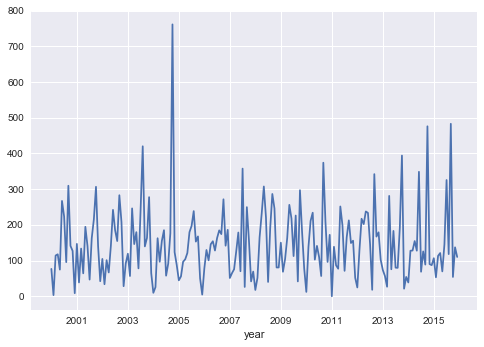

In [499]:
w_data['rain_sum'].plot()

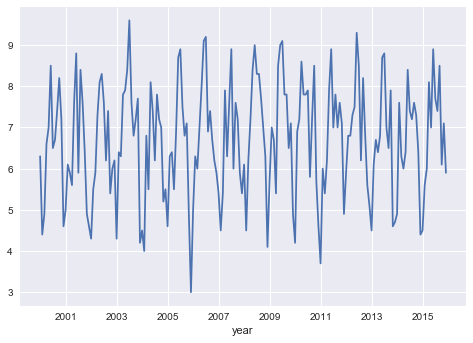

In [500]:
w_data['avg_cloud_quantity'].plot()

In [18]:
"""
##各移動平均と差分系列を取得
#気温
temp_data = w_data.loc[:,['avg_temp']]
temp_moving_avg = temp_data.rolling(window=12).mean().dropna()
temp_diff = temp_data.diff().dropna()
#日差し
sun_data = w_data.loc[:,['sun']]
sun_moving_avg = sun_data.rolling(window=12).mean().dropna()
sun_diff = sun_data.diff().dropna()
#雨量
rain_data = w_data.loc[:,['rain_sum']]
rain_moving_avg = rain_data.rolling(window=12).mean().dropna()
rain_diff = rain_data.diff().dropna()
"""
#風量
wind_data = w_data.loc[:,['avg_wind']]
wind_moving_avg = wind_data.rolling(window=12).mean().dropna()
wind_diff = wind_data.diff().dropna()
#雲量
cloud_data = w_data.loc[:,['avg_cloud_quantity']]
cloud_moving_avg = cloud_data.rolling(window=12).mean().dropna()
cloud_diff = cloud_data.diff().dropna()

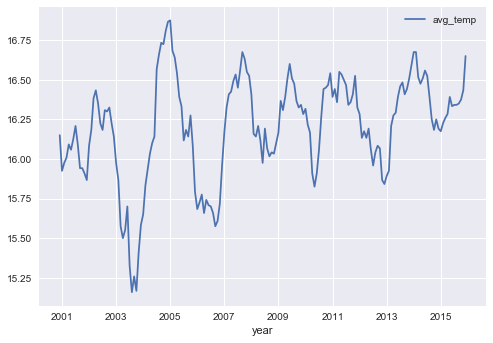

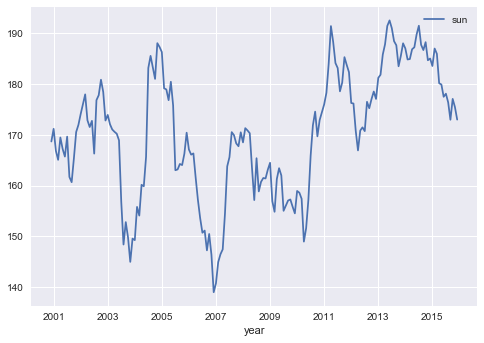

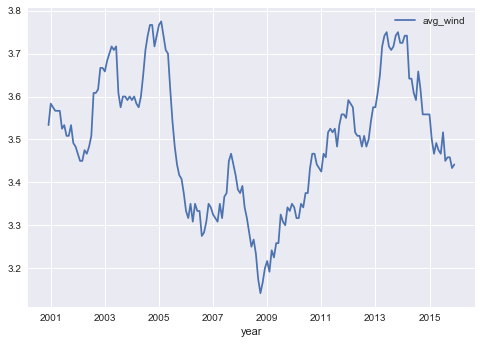

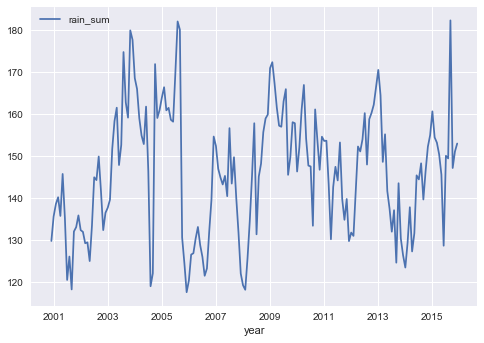

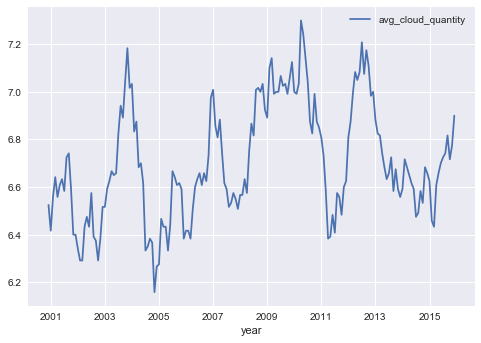

In [502]:
temp_moving_avg.plot()
sun_moving_avg.plot()
wind_moving_avg.plot()
rain_moving_avg.plot()
cloud_moving_avg.plot()

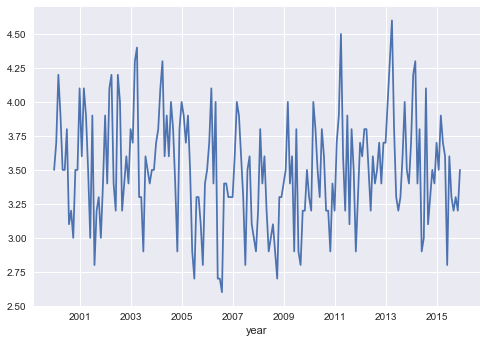

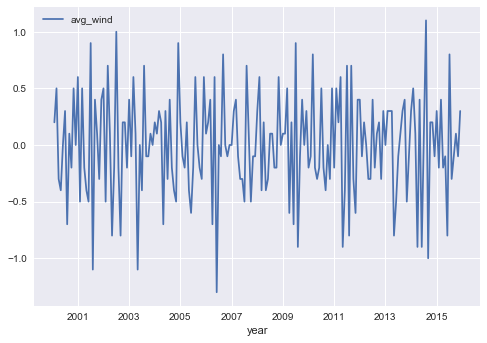

In [21]:
#差分系列のplot
#temp_diff.plot()
#sun_diff.plot()
w_data['avg_wind'].plot()
wind_diff.plot()
#rain_diff.plot()

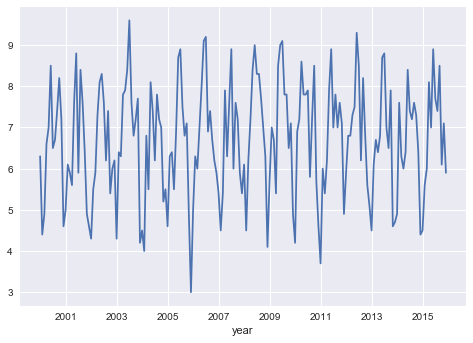

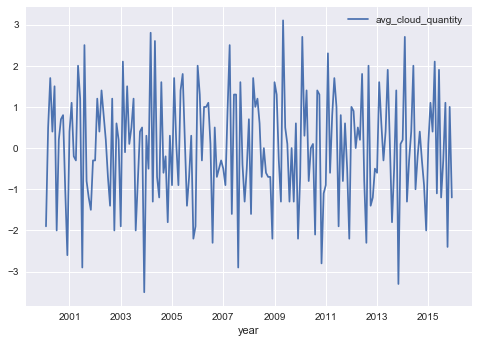

In [23]:
w_data['avg_cloud_quantity'].plot()
cloud_diff.plot()

In [25]:
#差分系列をADF検定
# https://logics-of-blue.com/time-series-regression/ むやみに差分系列を
#print (st.adfuller(temp_diff['avg_temp'].values.ravel()))
#print (st.adfuller(sun_diff['sun'].values.ravel()))
print (st.adfuller(wind_diff['avg_wind'].values.ravel()))
#print (st.adfuller(rain_diff['rain_sum'].values.ravel()))
print (st.adfuller(cloud_diff['avg_cloud_quantity'].values.ravel()))
# 差分をとることで雲量、風量共に単位根過程から定常過程へ移った。

(-12.10730820681971, 1.9554655283788218e-22, 10, 180, {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531}, 135.59317233937634)
(-10.686799428742827, 3.814864619840895e-19, 11, 179, {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}, 502.1098189982017)


In [30]:
#原系列の気温、日照時間、雨量と、差分系列の風速、雲量のデータを連携
#差分をとった際に、時系列の最初のデータ（2000-01-01)はNaNになるので、1月のデータを落として2月から開始にする。
diff_data = pd.concat([w_data.loc[:,['avg_temp','sun','rain_sum']],wind_diff,cloud_diff],axis=1).loc['2000-02-01':]

In [31]:
diff_data.head()

,avg_temp,sun,rain_sum,avg_wind,avg_cloud_quantity
year,,,,,
2000-02-01,5.6,198.9,3.0,0.2,-1.9
2000-03-01,9.0,202.7,114.0,0.5,0.5
2000-04-01,14.0,173.7,117.5,-0.3,1.7
2000-05-01,19.1,197.1,74.5,-0.4,0.4
2000-06-01,21.4,132.6,267.0,0.0,1.5


# 差分をとることで単位根過程から、定常過程になった
# 原系列と差分系列で相関分析〜
# ほんとは変数同士で、共和分検定をした方がいい (理想的には、VECM) が説明変数同士の相関関係をみるのにそこまでできない。

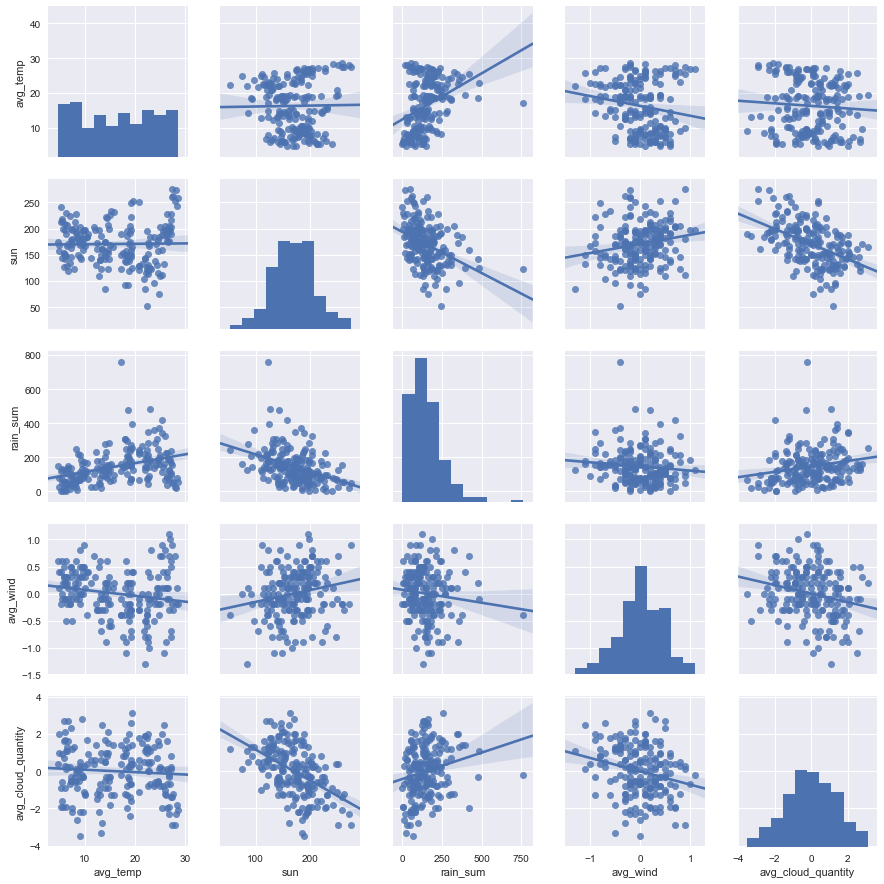

In [32]:
sns.pairplot(diff_data,kind='reg')

In [33]:
correlation_matrix = np.corrcoef(diff_data.transpose())

In [36]:
names = ['temp','sun','wind','rain','cloud']

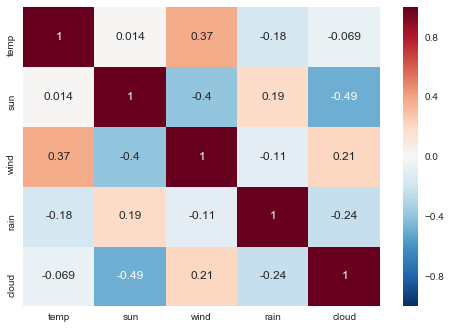

In [37]:
sns.heatmap(correlation_matrix, annot=True, xticklabels=names,yticklabels=names)

# Cloud quantityは日差しとか、気温とかとあまりにも相関するからバイバイする

In [509]:
w_data = w_data.drop(['avg_cloud_quantity'],axis=1)
diff_data = diff_data.drop(['avg_cloud_quantity'],axis=1)

# 横浜市のデータを読み込む！

# うまく書けなかった。。
num=2000
df = pd.DataFrame()

for i in range (15):
    df = df.append(pd.read_excel('yoko_econ.xlsx',sheetname=2016))
    num += 1

In [39]:
dat2000 = pd.read_excel('yoko_econ.xlsx',sheetname='2000').T.drop(['平均'],axis=0).reset_index()
dat2001 = pd.read_excel('yoko_econ.xlsx',sheetname='2001').T.drop(['平均'],axis=0).reset_index()
dat2002 = pd.read_excel('yoko_econ.xlsx',sheetname='2002').T.drop(['平均'],axis=0).reset_index()
dat2003 = pd.read_excel('yoko_econ.xlsx',sheetname='2003').T.drop(['平均'],axis=0).reset_index()
dat2004 = pd.read_excel('yoko_econ.xlsx',sheetname='2004').T.drop(['平均'],axis=0).reset_index()
dat2005 = pd.read_excel('yoko_econ.xlsx',sheetname='2005').T.drop(['平均'],axis=0).reset_index()
dat2006 = pd.read_excel('yoko_econ.xlsx',sheetname='2006').T.drop(['平均'],axis=0).reset_index()
dat2007 = pd.read_excel('yoko_econ.xlsx',sheetname='2007').T.drop(['平均'],axis=0).reset_index()
dat2008 = pd.read_excel('yoko_econ.xlsx',sheetname='2008').T.drop(['平均'],axis=0).reset_index()
dat2009 = pd.read_excel('yoko_econ.xlsx',sheetname='2009').T.drop(['平均'],axis=0).reset_index()
dat2010 = pd.read_excel('yoko_econ.xlsx',sheetname='2010').T.drop(['平均'],axis=0).reset_index()
dat2011 = pd.read_excel('yoko_econ.xlsx',sheetname='2011').T.drop(['平均'],axis=0).reset_index()
dat2012 = pd.read_excel('yoko_econ.xlsx',sheetname='2012').T.drop(['平均'],axis=0).reset_index()
dat2013 = pd.read_excel('yoko_econ.xlsx',sheetname='2013').T.drop(['平均'],axis=0).reset_index()
dat2014 = pd.read_excel('yoko_econ.xlsx',sheetname='2014').T.drop(['平均'],axis=0).reset_index()
dat2015 = pd.read_excel('yoko_econ.xlsx',sheetname='2015').T.drop(['平均'],axis=0).reset_index()
#dat2016は平均値をもたないよ（）
#http://www.city.yokohama.lg.jp/ex/stat/toukeisho/new/index3.html#12 データソース

/Users/Taishi/anaconda/lib/python3.6/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [40]:
#横浜市のデータを縦型に突合する
dat = pd.concat([dat2000,dat2001,dat2002,dat2003,dat2004,dat2005,dat2006,dat2007,dat2008,dat2009,dat2010,dat2011,dat2012,dat2013,dat2014,dat2015],axis=0)

In [97]:
tar_data = dat.set_index('index').loc[:,['消費支出','食料','住居','光熱・水道','家具・家事用品','被服及び履物','保健医療','交通・通信','教育','教養娯楽','その他の消費支出']]

In [98]:
#原系列に対するADF検定
print (st.adfuller(tar_data['消費支出'].values.ravel()))
print (st.adfuller(tar_data['食料'].values.ravel()))
print (st.adfuller(tar_data['住居'].values.ravel()))
print (st.adfuller(tar_data['光熱・水道'].values.ravel()))
print (st.adfuller(tar_data['家具・家事用品'].values.ravel()))
print (st.adfuller(tar_data['被服及び履物'].values.ravel()))
print (st.adfuller(tar_data['保健医療'].values.ravel()))
print (st.adfuller(tar_data['交通・通信'].values.ravel()))
print (st.adfuller(tar_data['教育'].values.ravel()))
print (st.adfuller(tar_data['教養娯楽'].values.ravel()))

(-1.8142038948570183, 0.3734330038095893, 11, 180, {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531}, 4069.5035305453284)
(-2.8598647489026443, 0.050218207064792124, 13, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 3074.4091909200088)
(-5.786426110743261, 4.987099498973615e-07, 2, 189, {'1%': -3.4654311561944873, '5%': -2.8769570530458792, '10%': -2.574988319755886}, 3669.275970009311)
(-4.0662669702101875, 0.0011006248966932929, 13, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 3083.2184115307628)
(-5.024454015795098, 1.984843148415581e-05, 9, 374, {'1%': -3.4479562840494475, '5%': -2.869299109917524, '10%': -2.57090345105665}, 6703.186418351657)
(-3.5451502867737474, 0.006900487688402369, 11, 372, {'1%': -3.4480516066132636, '5%': -2.869340997473759, '10%': -2.5709257824604}, 6778.341365759103)
(-11.278548168300956, 1.4756880765410396e-20, 0, 191, {'1%': -3.465058702600837, 

In [99]:
##各移動平均と差分系列を取得
#消費
consumption_data = tar_data.loc[:,['消費支出']]
#consumption_moving_avg = consumption_data.rolling(window=12).mean().dropna()
consumption_diff = consumption_data.diff().dropna()
consumption_diff.columns = ['consumption']
"""
#食料
food_data = tar_data.loc[:,['食料']]
food_moving_avg = food_data.rolling(window=12).mean().dropna()
food_diff = food_data.diff().dropna()
#住居
estate_data = tar_data.loc[:,['住居']]
estate_moving_avg = estate_data.rolling(window=12).mean().dropna()
estate_diff = estate_data.diff().dropna()
#光熱、水道
utility_data = tar_data.loc[:,['光熱・水道']]
utility_moving_avg = utility_data.rolling(window=12).mean().dropna()
utility_diff = utility_data.diff().dropna()
#家具・家事用品
furniture_data = tar_data.loc[:,['家具・家事用品']]
furniture_moving_avg = furniture_data.rolling(window=12).mean().dropna()
furniture_diff = furniture_data.diff().dropna()
#被服及び履物
cloth_data = tar_data.loc[:,['被服及び履物']]
cloth_moving_avg = cloth_data.rolling(window=12).mean().dropna()
cloth_diff = cloth_data.diff().dropna()
#保健医療
medical_data = tar_data.loc[:,['保健医療']]
medical_moving_avg = medical_data.rolling(window=12).mean().dropna()
medical_diff = medical_data.diff().dropna()
#風量
com_data = tar_data.loc[:,['交通・通信']]
com_moving_avg = com_data.rolling(window=12).mean().dropna()
com_diff = com_data.diff().dropna()
#教育
edu_data = tar_data.loc[:,['教育']]
edu_moving_avg = edu_data.rolling(window=12).mean().dropna()
edu_diff = edu_data.diff().dropna()
#雲量
edu_fun_data = tar_data.loc[:,['教養娯楽']]
edu_fun_moving_avg = edu_fun_data.rolling(window=12).mean().dropna()
edu_fun_diff = edu_fun_data.diff().dropna()
"""

"\n#食料\nfood_data = tar_data.loc[:,['食料']]\nfood_moving_avg = food_data.rolling(window=12).mean().dropna()\nfood_diff = food_data.diff().dropna()\n#住居\nestate_data = tar_data.loc[:,['住居']]\nestate_moving_avg = estate_data.rolling(window=12).mean().dropna()\nestate_diff = estate_data.diff().dropna()\n#光熱、水道\nutility_data = tar_data.loc[:,['光熱・水道']]\nutility_moving_avg = utility_data.rolling(window=12).mean().dropna()\nutility_diff = utility_data.diff().dropna()\n#家具・家事用品\nfurniture_data = tar_data.loc[:,['家具・家事用品']]\nfurniture_moving_avg = furniture_data.rolling(window=12).mean().dropna()\nfurniture_diff = furniture_data.diff().dropna()\n#被服及び履物\ncloth_data = tar_data.loc[:,['被服及び履物']]\ncloth_moving_avg = cloth_data.rolling(window=12).mean().dropna()\ncloth_diff = cloth_data.diff().dropna()\n#保健医療\nmedical_data = tar_data.loc[:,['保健医療']]\nmedical_moving_avg = medical_data.rolling(window=12).mean().dropna()\nmedical_diff = medical_data.diff().dropna()\n#風量\ncom_data = tar_data.loc[:,['交通

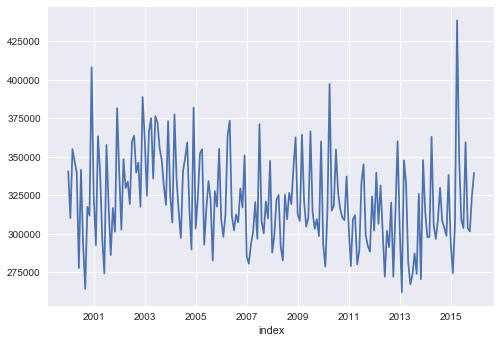

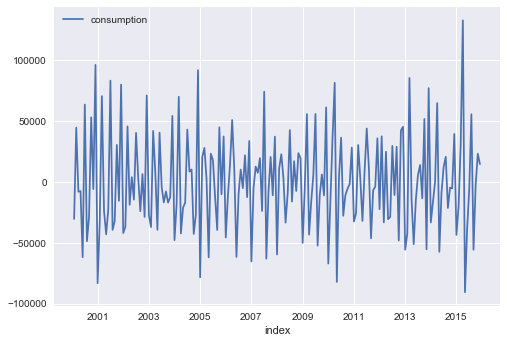

In [100]:
tar_data['消費支出'].plot()
consumption_diff.plot()

In [48]:
#差分系列に対するADF検定
"""
print (st.adfuller(tar_data['食料'].values.ravel()))
print (st.adfuller(tar_data['住居'].values.ravel()))
print (st.adfuller(tar_data['光熱・水道'].values.ravel()))
print (st.adfuller(tar_data['家具・家事用品'].values.ravel()))
print (st.adfuller(tar_data['被服及び履物'].values.ravel()))
print (st.adfuller(tar_data['保健医療'].values.ravel()))
print (st.adfuller(tar_data['交通・通信'].values.ravel()))
print (st.adfuller(tar_data['教育'].values.ravel()))
print (st.adfuller(tar_data['教養娯楽'].values.ravel()))
"""
st.adfuller(consumption_diff.values.ravel())
#pvalue < 0.05, 差分をとったことによる差分系列になった

(-8.00045229539132,
 2.3416464404906063e-12,
 10,
 180,
 {'1%': -3.4672111510631, '10%': -2.575403364197531, '5%': -2.877734766803841},
 4047.3788406504073)

In [50]:
tar_data.columns = [
    'consumption'
    ,'food'
    ,'estate'
    ,'utility'
    ,'furniture'
    ,'furniture_2'
    ,'cloth'
    ,'cloth_2'
    ,'medical'
    ,'telecom'
    ,'education'
    ,'edu_fun'
    ,'edu_fun_2'
    ,'else'
]

'\nfood_diff.plot()\nestate_diff.plot()\nutility_diff.plot()\nfurniture_diff.plot()\ncloth_diff.plot()\nmedical_diff.plot()\ncom_diff.plot()\nedu_diff.plot()\nedu_fun_diff.plot()\n'

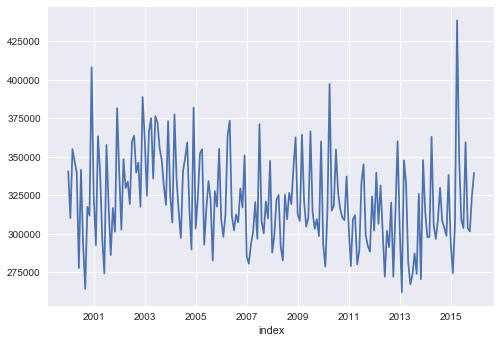

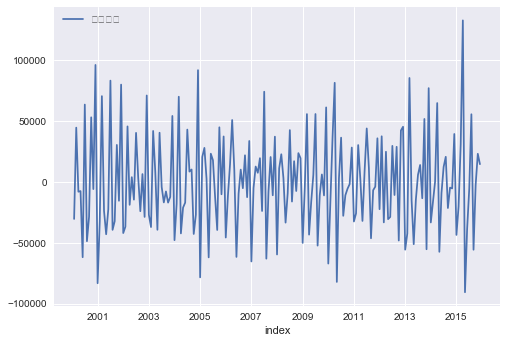

In [52]:
#差分
tar_data['consumption'].plot()
consumption_diff.plot()
"""
food_diff.plot()
estate_diff.plot()
utility_diff.plot()
furniture_diff.plot()
cloth_diff.plot()
medical_diff.plot()
com_diff.plot()
edu_diff.plot()
edu_fun_diff.plot()
"""

In [57]:
#diff_data_2 = pd.concat([consumption_diff,w_data.drop(['消費支出'],axis=1)],axis=1)

In [58]:
'''
diff_data_2.columns = [
    'consumption'
    ,'food'
    ,'estate'
    ,'utility'
    ,'furniture'
    ,'furniture_2'
    ,'cloth'
    ,'cloth_2'
    ,'medical'
    ,'telecom'
    ,'education'
    ,'edu_fun'
    ,'edu_fun_2'
]
'''

"\ndiff_data_2.columns = [\n    'consumption'\n    ,'food'\n    ,'estate'\n    ,'utility'\n    ,'furniture'\n    ,'furniture_2'\n    ,'cloth'\n    ,'cloth_2'\n    ,'medical'\n    ,'telecom'\n    ,'education'\n    ,'edu_fun'\n    ,'edu_fun_2'\n]\n"

In [101]:
#x_train = 説明変数群
#y_train = 目的変数
x_train = diff_data.drop(['avg_cloud_quantity'],axis=1)
y_train = consumption_diff

# まずは、自己回帰や！
# https://logics-of-blue.com/time-series-forecast-by-machine-learning/ 参考

# まずはARモデル！！

In [103]:
#消費支出のみでの自己相関
ts_acf = st.acf(y_train,nlags=40)
print (ts_acf)

[ 1.         -0.3780117  -0.25390004  0.03277107  0.22950429 -0.02290466
 -0.23781948  0.06674476  0.10385042  0.13280119 -0.23435538 -0.19677877
  0.45945653 -0.10550038 -0.21517809  0.05845617  0.14740541  0.04133664
 -0.22747373 -0.00472768  0.19665222  0.06548124 -0.18082151 -0.22573833
  0.43050819 -0.11362272 -0.14837514 -0.00877914  0.12995693  0.12214752
 -0.27948631  0.03829691  0.10730501  0.14927712 -0.26689704 -0.05971039
  0.32151098 -0.15705281 -0.07782269 -0.01113084  0.13267684]


In [104]:
#消費支出のみでの偏自己相関
par_ts_acf_2 = st.pacf(y_train.values.ravel(),nlags=40)
print (par_ts_acf_2)

[ 1.00000000e+00 -3.80001234e-01 -4.68663154e-01 -4.31347375e-01
 -1.58634278e-01 -7.18445556e-03 -1.84688714e-01 -1.97001823e-01
 -2.33773750e-01  8.59405187e-02  2.74619471e-02 -4.16355114e-01
  4.13931548e-03 -6.22121005e-02 -1.68529803e-01  3.26157741e-04
 -9.55304719e-02  7.29522624e-02  1.51865908e-02 -1.82006910e-01
  1.14367432e-01  1.42449180e-01  1.83315251e-01 -8.69063113e-02
  8.25582771e-02 -1.43184361e-02  3.21016073e-02 -1.22070742e-02
 -1.15464838e-01  7.08293945e-02 -1.54575325e-01 -8.42568758e-02
 -9.14169906e-02  2.23592911e-02 -1.87765325e-01 -1.16186116e-01
  5.12184956e-02 -2.13903586e-01 -8.60752480e-02 -1.09818532e-01
 -4.58058614e-02]


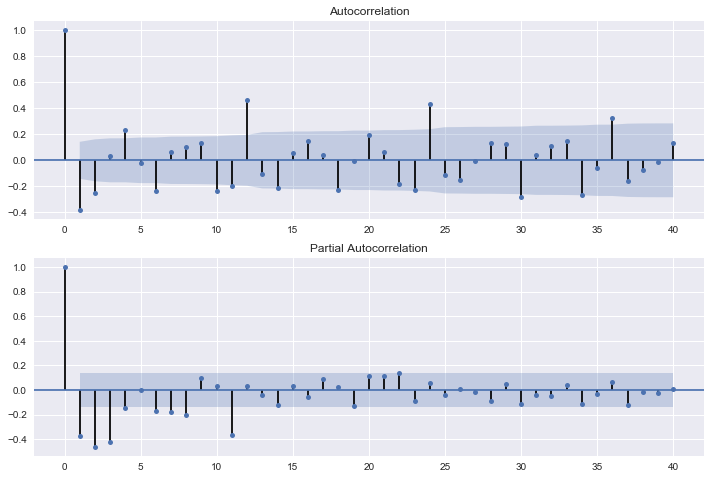

In [105]:
# 自己相関のグラフ
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_train.values.ravel(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_train.values.ravel(), lags=40, ax=ax2)

# autocorrelation の方で、12期つまり1年毎の周期が観測されているよね

# ARMAモデルやるよ！！

In [106]:
#ARMAの次数推定
sm.tsa.arma_order_select_ic(y_train, ic='aic', trend='nc')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


{'aic':              0            1            2
 0          NaN  4477.689554  4479.572715
 1  4561.552176  4479.633540  4479.286147
 2  4517.503367  4469.644548  4471.626066
 3  4482.139335  4471.595376  4472.645620
 4  4480.103356  4467.398990  4469.389970, 'aic_min_order': (4, 1)}

In [107]:
arma = ARMA(y_train,order = [4,1,1]).fit(dist=False)
print (arma.params)

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


const               -137.016297
ar.L1.consumption      0.081099
ar.L2.consumption     -0.118261
ar.L3.consumption      0.106270
ar.L4.consumption      0.256129
ma.L1.consumption     -1.000000
dtype: float64


/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


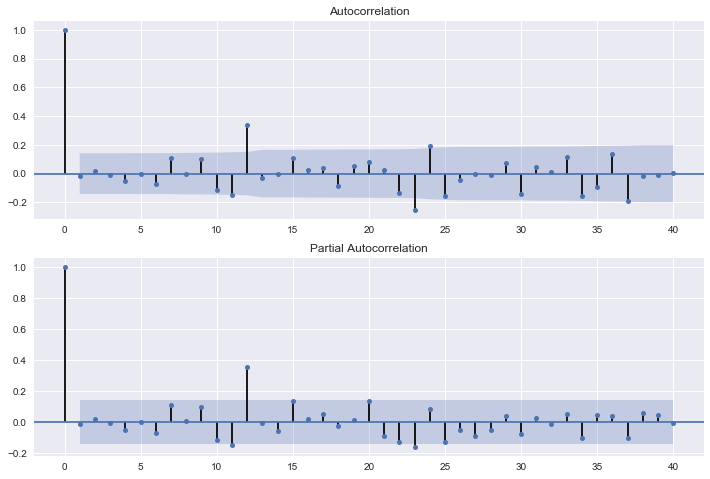

In [108]:
#残差の周期性を確認する
resid = arma.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

# 周期残ってそう

In [109]:
#summary
arma.summary()

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            consumption   No. Observations:                  191
Model:                     ARMA(4, 1)   Log Likelihood               -2226.737
Method:                       css-mle   S.D. of innovations          27629.268
Date:                Wed, 17 Jan 2018   AIC                           4467.474
Time:                        01:49:30   BIC                           4490.240
Sample:                    02-01-2000   HQIC                          4476.695
                         - 12-01-2015                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -137.0163     51.906     -2.640      0.009    -238.751     -35.282
ar.L1.consumption     0.0811      0.070      1.153      0.251      -0.057       0.219
ar.L2.consumption    -0.1183      0.070     -1.691      0.093      -0.255       0.019
ar.L3.consumption     0.1063      0.070      1.517      0.131      -0.031       0.244
ar.L4.consumption     0.2561      0.070      3.658      0.000       0.119       0.393
ma.L1.consumption    -1.0000      0.017    -59.037      0.000      -1.033      -0.967
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3478           -0.0000j            1.3478           -0.0000
AR.2           -0.0511           -1.3198j            1.3208           -0.2562
AR.3           -0.0511           +1.3198j            1.3208            0.2562
AR.4           -1.6605           -0.0000j            1.6605           -0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [110]:
arma_pred = arma.predict('2000-02-01','2016-12-01')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


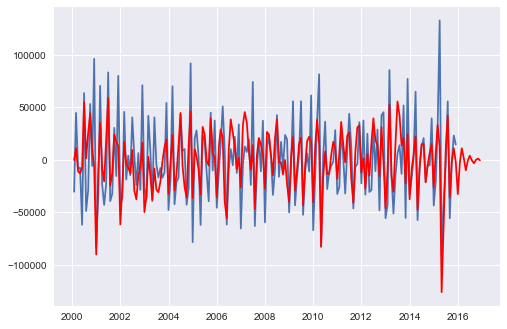

In [111]:
plt.plot(y_train)
plt.plot(arma_pred, "r")

# そのまま ARIMAもやるよ!!

In [112]:
arima = ARIMA(y_train,order = [4,1,1]).fit(dist=False)
print (arima.params)

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


const                  2.801584
ar.L1.D.consumption   -0.806488
ar.L2.D.consumption   -0.792665
ar.L3.D.consumption   -0.523798
ar.L4.D.consumption   -0.140475
ma.L1.D.consumption   -0.999964
dtype: float64


/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


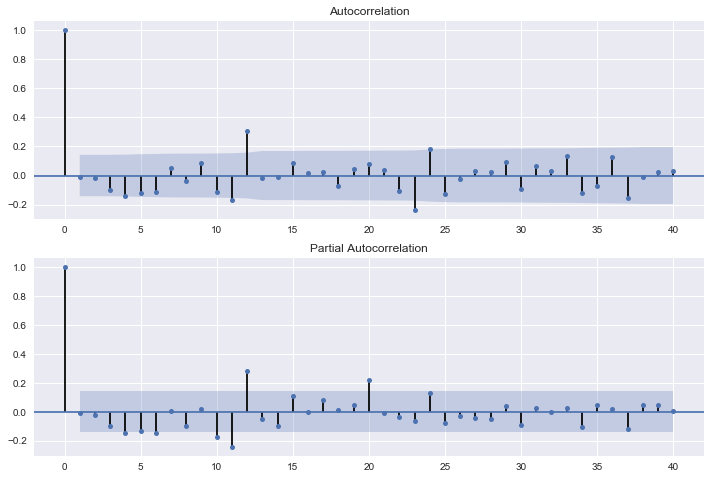

In [113]:
resid = arima.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [114]:
arima.summary()

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.consumption   No. Observations:                  190
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -2227.621
Method:                       css-mle   S.D. of innovations          29201.669
Date:                Wed, 17 Jan 2018   AIC                           4469.242
Time:                        01:49:34   BIC                           4491.971
Sample:                    03-01-2000   HQIC                          4478.449
                         - 12-01-2015                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.8016     12.004      0.233      0.816     -20.726      26.329
ar.L1.D.consumption    -0.8065      0.072    -11.216      0.000      -0.947      -0.666
ar.L2.D.consumption    -0.7927      0.085     -9.376      0.000      -0.958      -0.627
ar.L3.D.consumption    -0.5238      0.084     -6.206      0.000      -0.689      -0.358
ar.L4.D.consumption    -0.1405      0.072     -1.954      0.052      -0.281       0.000
ma.L1.D.consumption    -1.0000      0.014    -73.158      0.000      -1.027      -0.973
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0498           -1.2696j            1.2706           -0.2438
AR.2            0.0498           +1.2696j            1.2706            0.2438
AR.3           -1.9142           -0.8635j            2.0999           -0.4326
AR.4           -1.9142           +0.8635j            2.0999            0.4326
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [115]:
arima_pred = arima.predict('2000-03-01','2016-12-01')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


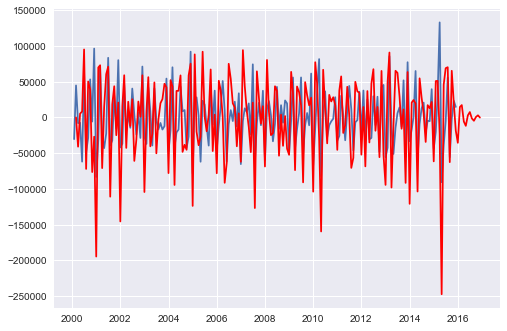

In [116]:
plt.plot(y_train)
plt.plot(arima_pred, "r")

# SARIMAXをつかうんじゃー！

In [117]:
sarimax = SARIMAX(y_train, order=(4,1,1), seasonal_order=(1,1,1,12)).fit(dist=False)

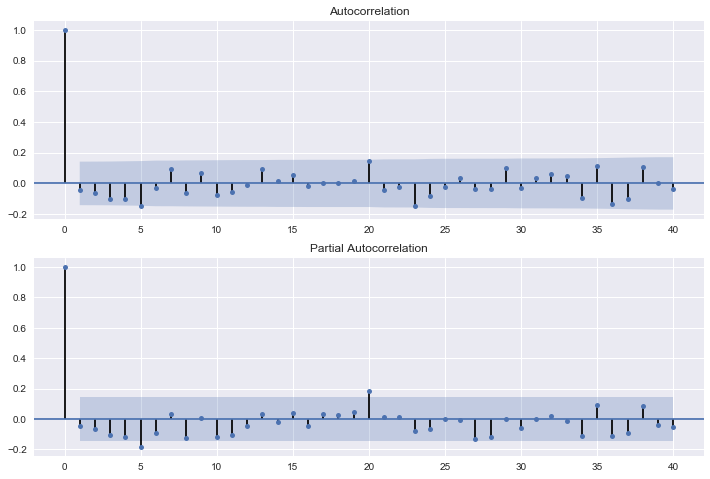

In [118]:
resid = sarimax.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

# 周期性消えてそう

In [119]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        consumption   No. Observations:                  191
Model:             SARIMAX(4, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2083.385
Date:                            Wed, 17 Jan 2018   AIC                           4182.771
Time:                                    01:49:41   BIC                           4208.789
Sample:                                02-01-2000   HQIC                          4193.309
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6324      0.211     -3.001      0.003      -1.045      -0.219
ar.L2         -0.4693      0.268     -1.749      0.080      -0.995       0.057
ar.L3         -0.3191      0.245     -1.303      0.193      -0.799       0.161
ar.L4         -0.0727      0.211     -0.344      0.731      -0.487       0.341
ma.L1         -0.9791      0.170     -5.751      0.000      -1.313      -0.645
ar.S.L12       0.0275      0.334      0.082      0.935      -0.628       0.683
ma.S.L12      -0.7413      0.321     -2.310      0.021      -1.370      -0.112
sigma2      1.462e+09   1.18e-10   1.23e+19      0.000    1.46e+09    1.46e+09
===================================================================================
Ljung-Box (Q):                       58.43   Jarque-Bera (JB):                68.09
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                             1.13
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.71e+35. Standard errors may be unstable.
"""

In [120]:
sarimax_pred = sarimax.predict('2000-02-01','2016-12-01')

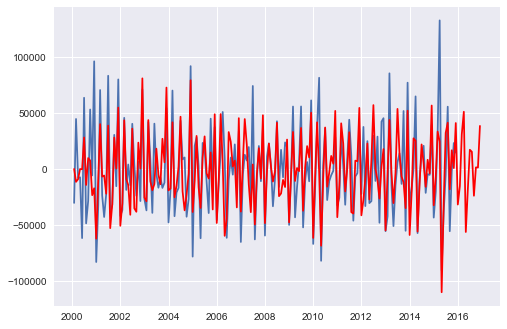

In [121]:
plt.plot(y_train)
plt.plot(sarimax_pred, "r")

In [122]:
#予測データデータフレームの形成
y_arma_pred = pd.DataFrame(arma_pred).loc['2016-01-01':'2016-10-01']
y_arima_pred = pd.DataFrame(arima_pred).loc['2016-01-01':'2016-10-01']
y_sarimax_pred = pd.DataFrame(sarimax_pred).loc['2016-01-01':'2016-10-01']

In [95]:
#目的変数のテストデータを読み込む
dat2016 = pd.read_excel('yoko_econ.xlsx',sheetname='2016').T

/Users/Taishi/anaconda/lib/python3.6/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [123]:
y_test = dat2016.loc[:,['消費支出']].dropna()
y_test.columns = ['consumption']

In [124]:
# 平均二乗誤差を評価するためのメソッドを呼び出し
from sklearn.metrics import mean_squared_error
# 検証用データに関して平均二乗誤差を出力
print (sqrt(mean_squared_error(y_test, y_arma_pred)))
print (sqrt(mean_squared_error(y_test, y_arima_pred)))
print (sqrt(mean_squared_error(y_test, y_sarimax_pred)))

337666.0782024016
336224.9541796184
336963.3742661641


# ARMAモデルが一番評価高いジャンwww
## ARMA > SARIMA > ARIMA

# VARモデルで推測じゃ

In [125]:
#差分に対してrandom forestすることでどれが目的変数に影響あるかを調べる
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(x_train, y_train)
print('Training done using Random Forest')

/Users/Taishi/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Training done using Random Forest


/Users/Taishi/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


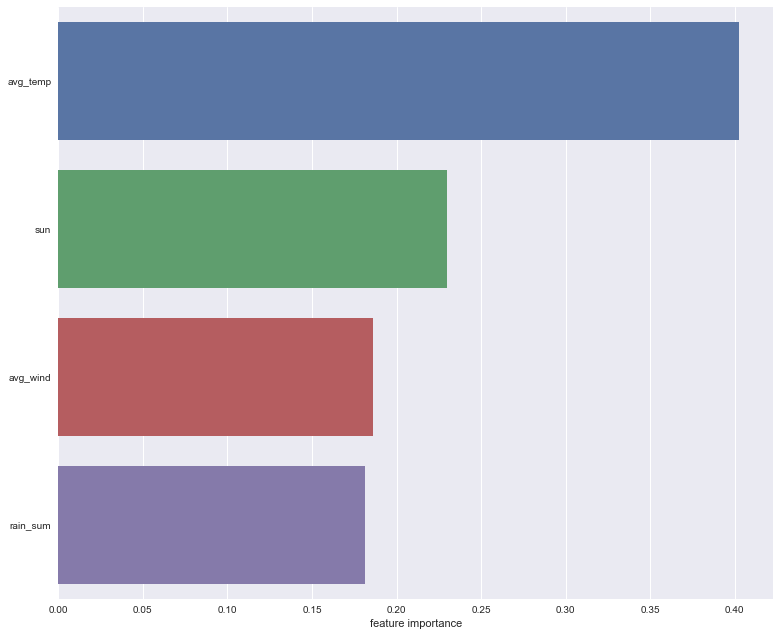

In [126]:
#plot
ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking], y=x_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [139]:
from statsmodels.tsa.api import VAR, DynamicVAR
var_data = pd.concat([x_train,y_train],axis=1)

In [140]:
var_data.head()

,avg_temp,sun,rain_sum,avg_wind,consumption
2000-02-01,5.6,198.9,3.0,0.2,-30346.0
2000-03-01,9.0,202.7,114.0,0.5,44758.0
2000-04-01,14.0,173.7,117.5,-0.3,-7959.0
2000-05-01,19.1,197.1,74.5,-0.4,-7416.0
2000-06-01,21.4,132.6,267.0,0.0,-61825.0


In [141]:
model = VAR(var_data)

In [142]:
model.select_order(12)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         39.70        39.79    1.738e+17        39.73
1         37.97        38.50    3.080e+16        38.18
2         36.05        37.03    4.542e+15        36.45
3         35.45       36.87*    2.493e+15        36.03
4         35.21        37.08    1.975e+15       35.97*
5         35.14        37.45    1.837e+15        36.08
6         35.18        37.94    1.928e+15        36.30
7         35.13        38.34    1.859e+15        36.43
8         35.14        38.79    1.909e+15        36.62
9         35.17        39.27    2.002e+15        36.83
10        35.25        39.79    2.198e+15        37.09
11       34.98*        39.97   1.740e+15*        37.01
12        35.01        40.44    1.843e+15        37.21
* Minimum



/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


{'aic': 11, 'bic': 3, 'fpe': 11, 'hqic': 4}

In [153]:
#モデルはaic
var_result = model.fit(maxlags=12, ic='aic')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


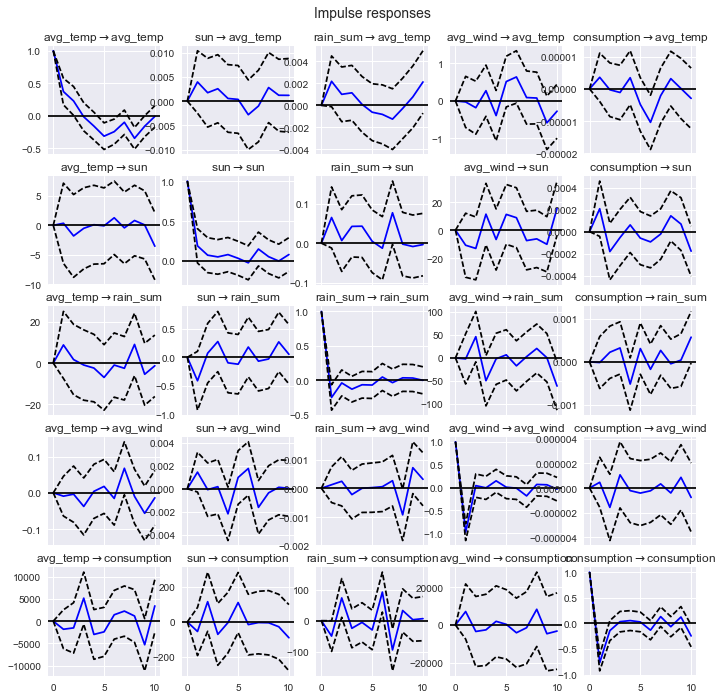

In [154]:
irf = var_result.irf(10)
irf.plot(orth=False)

In [155]:
var_result_aic.test_causality('consumption', ['avg_temp','rain_sum','sun'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.397903         1.455309            0.071  (33, 620)
H_0: ['avg_temp', 'rain_sum', 'sun'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4553091470106816,
 'df': (33, 620),
 'pvalue': 0.07106709099462163,
 'signif': 0.05,
 'statistic': 1.397903486939458}

## ムー因果関係がないと出てしまっている（windは覗くのが一番いいpvalueが低い）
## 他のデータをつかっちゃおう！

In [212]:
#雪とか、日別最高気温月平均とか
new_data = pd.read_csv('data5.csv', index_col='year',parse_dates=True)

In [214]:
print (st.adfuller(new_data['daily_low_temp'].values.ravel()))
print (st.adfuller(new_data['daily_high_temp'].values.ravel()))
print (st.adfuller(new_data['snow'].values.ravel()))

(-2.637142116850712, 0.08556111667095184, 11, 192, {'1%': -3.4648754262570978, '5%': -2.876714157488788, '10%': -2.574858699001736}, 574.2828019006081)
(-3.693963407361943, 0.004198869899776495, 15, 188, {'1%': -3.465620397124192, '5%': -2.8770397560752436, '10%': -2.5750324547306476}, 647.1928519822028)
(-14.530761247364511, 5.336287013911243e-27, 0, 203, {'1%': -3.462980134086401, '5%': -2.875885461947131, '10%': -2.5744164898444515}, 1008.7993722284343)


In [224]:
high_temp_org = new_data.loc[:,['daily_high_temp']].loc['2000-02-01':]
low_temp_diff = pd.DataFrame(new_data['daily_low_temp'].diff().dropna())
#high_temp_diff = pd.DataFrame(new_data['daily_high_temp'].diff().dropna())
#snow_diff = pd.DataFrame(new_data['snow'].diff().dropna())

# いえーい定常過程だね
# じゃあ、そのまま相関関係見ちゃお

In [236]:
new_diff_data = pd.concat([low_temp_diff,high_temp_org],axis=1)

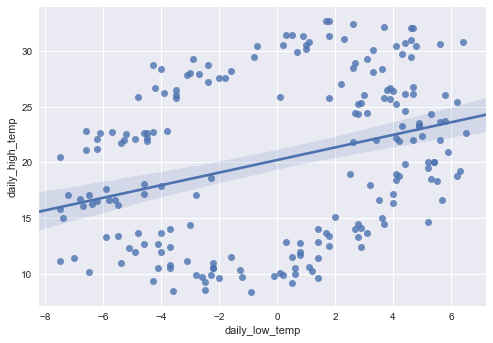

In [239]:
sns.regplot(x=low_temp_diff['daily_low_temp'] ,y=high_temp_org['daily_high_temp'])

# どっちかしかつかえないね。

In [245]:
var_data_2 = pd.concat([x_train,y_train,new_data],axis=1).loc[:'2015-12-01'].dropna()
var_data_3 = pd.concat([x_train,y_train,new_diff_data],axis=1).loc[:'2015-12-01'].dropna()

In [247]:
#model2は原系列のみ
model2 = VAR(var_data_2)
#model3は差分系列と原系列
model3 = VAR(var_data_3)

In [249]:
model3.select_order(12)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         39.39        39.51    1.278e+17        39.44
1         30.79        31.79    2.354e+13        31.19
2         29.74       31.61*    8.231e+12       30.49*
3         29.45        32.19    6.223e+12        30.56
4         29.04        32.66    4.180e+12        30.51
5         28.99        33.47   4.028e+12*        30.80
6         29.12        34.48    4.758e+12        31.30
7         29.09        35.32    4.777e+12        31.62
8         28.97        36.08    4.501e+12        31.86
9         29.10        37.08    5.491e+12        32.34
10        29.16        38.01    6.363e+12        32.75
11        28.89        38.61    5.456e+12        32.83
12       28.89*        39.48    6.273e+12        33.18
* Minimum



/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


{'aic': 12, 'bic': 2, 'fpe': 5, 'hqic': 2}

In [284]:
var_data_2.head()

,avg_temp,sun,rain_sum,avg_wind,consumption,snow,daily_high_temp,daily_low_temp
2000-02-01,5.6,198.9,3.0,0.2,-30346.0,0,9.9,1.7
2000-03-01,9.0,202.7,114.0,0.5,44758.0,0,13.7,4.8
2000-04-01,14.0,173.7,117.5,-0.3,-7959.0,0,18.5,10.1
2000-05-01,19.1,197.1,74.5,-0.4,-7416.0,0,23.7,15.9
2000-06-01,21.4,132.6,267.0,0.0,-61825.0,0,25.2,18.7


In [250]:
var_result_2 = model2.fit(maxlags=12, ic='aic')
var_result_3 = model3.fit(maxlags=12, ic='aic')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


In [291]:
var_result_2.test_causality('consumption', ['rain_sum','sun','daily_high_temp'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.257179         1.434920            0.147  (36, 656)
H_0: ['rain_sum', 'sun', 'daily_high_temp'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4349202284828888,
 'df': (36, 656),
 'pvalue': 0.14707678231532959,
 'signif': 0.05,
 'statistic': 1.2571790849080446}

In [293]:
var_result_2.test_causality('consumption', ['rain_sum','sun','daily_low_temp'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         0.978289         1.434920            0.507  (36, 656)
H_0: ['rain_sum', 'sun', 'daily_low_temp'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4349202284828888,
 'df': (36, 656),
 'pvalue': 0.5070940174748911,
 'signif': 0.05,
 'statistic': 0.9782893141999229}

In [294]:
var_result_2.test_causality('consumption', ['rain_sum','sun','avg_temp'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.087719         1.434920            0.336  (36, 656)
H_0: ['rain_sum', 'sun', 'avg_temp'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4349202284828888,
 'df': (36, 656),
 'pvalue': 0.33598933489870925,
 'signif': 0.05,
 'statistic': 1.0877193497752808}

In [295]:
var_result_3.test_causality('consumption', ['rain_sum','sun','daily_high_temp'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.142642         1.434865            0.263  (36, 658)
H_0: ['rain_sum', 'sun', 'daily_high_temp'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4348647824684353,
 'df': (36, 658),
 'pvalue': 0.2632696405237387,
 'signif': 0.05,
 'statistic': 1.1426419207038103}

In [296]:
var_result_3.test_causality('consumption', ['rain_sum','sun','daily_low_temp'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         0.978267         1.434865            0.507  (36, 658)
H_0: ['rain_sum', 'sun', 'daily_low_temp'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4348647824684353,
 'df': (36, 658),
 'pvalue': 0.5071263029945785,
 'signif': 0.05,
 'statistic': 0.9782672836552044}

In [297]:
var_result_3.test_causality('consumption', ['rain_sum','sun','avg_temp'], kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         1.057155         1.434865            0.381  (36, 658)
H_0: ['rain_sum', 'sun', 'avg_temp'] do not Granger-cause consumption
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 1.4348647824684353,
 'df': (36, 658),
 'pvalue': 0.3807570983329137,
 'signif': 0.05,
 'statistic': 1.0571550785284163}

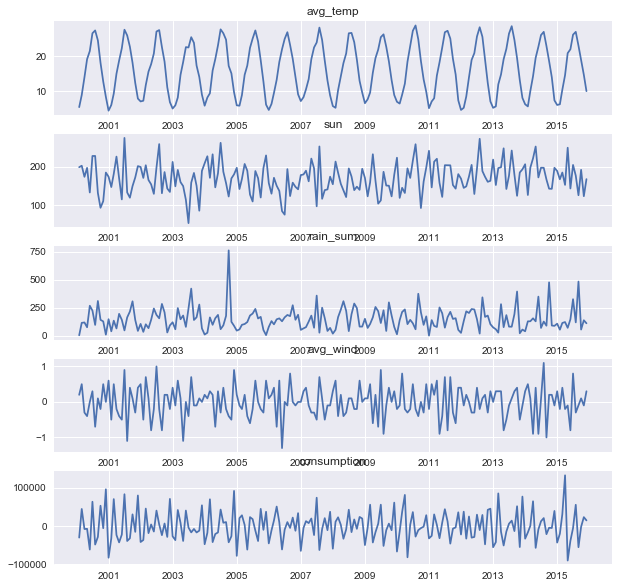

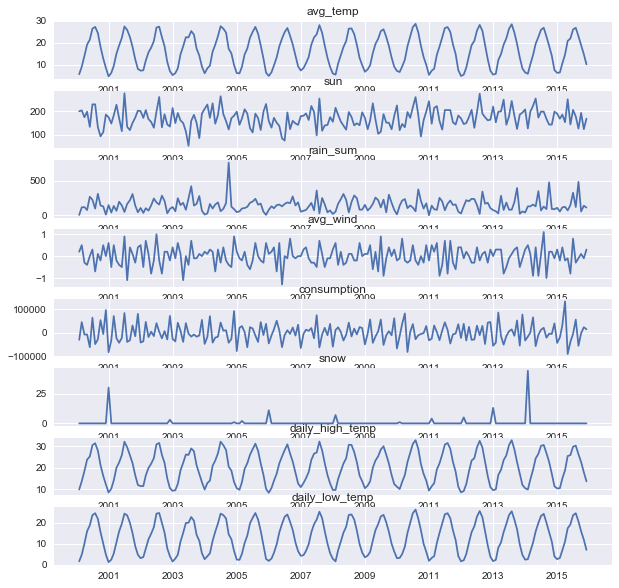

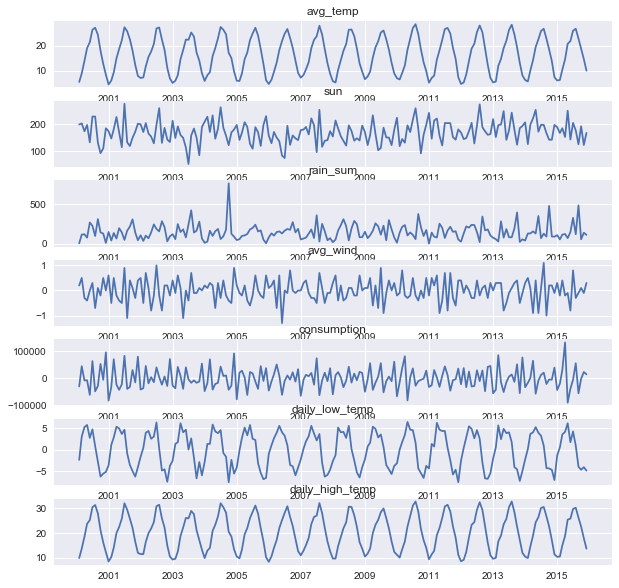

In [265]:
var_result.plot()
var_result_2.plot()
var_result_3.plot()

In [270]:
#差分に対してrandom forestすることでどれが目的変数に影響あるかを調べる
rf.fit(var_data_3.drop(['consumption'],axis=1) , y_train)
print('Training done using Random Forest')

Training done using Random Forest


/Users/Taishi/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [298]:
var_data_3 = var_data_3.drop(['consumption'],axis=1)

ValueError: labels ['consumption'] not contained in axis

/Users/Taishi/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


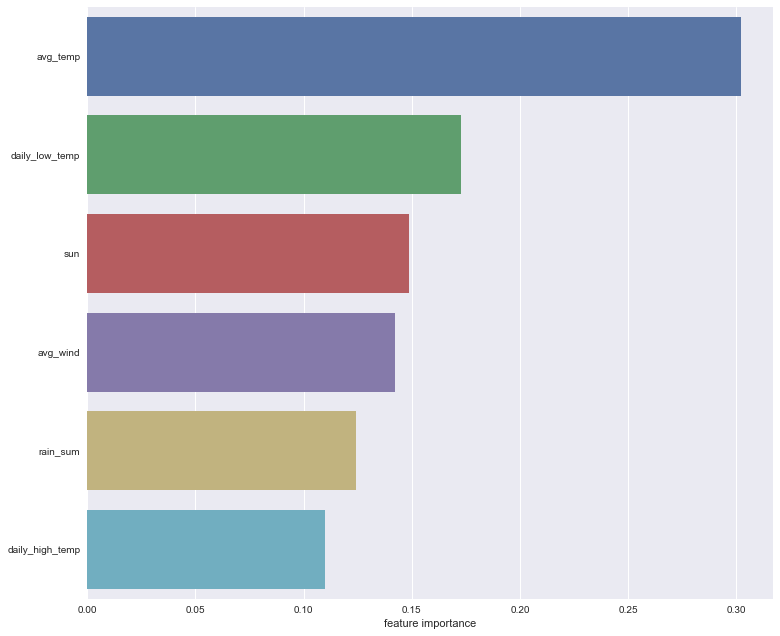

In [299]:
#plot
ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking], y=var_data_3.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

# Granger因果で、相関分析！！

In [301]:
granger_temp = st.grangercausalitytests(var_data_2.loc[:,['consumption','avg_temp']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3022  , p=0.5832  , df_denom=187, df_num=1
ssr based chi2 test:   chi2=0.3071  , p=0.5795  , df=1
likelihood ratio test: chi2=0.3068  , p=0.5796  , df=1
parameter F test:         F=0.3022  , p=0.5832  , df_denom=187, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3403  , p=0.7120  , df_denom=184, df_num=2
ssr based chi2 test:   chi2=0.6992  , p=0.7050  , df=2
likelihood ratio test: chi2=0.6979  , p=0.7054  , df=2
parameter F test:         F=0.3403  , p=0.7120  , df_denom=184, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3972  , p=0.2452  , df_denom=181, df_num=3
ssr based chi2 test:   chi2=4.3537  , p=0.2257  , df=3
likelihood ratio test: chi2=4.3041  , p=0.2304  , df=3
parameter F test:         F=1.3972  , p=0.2452  , df_denom=181, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4322  , p=0.2252  

In [302]:
granger_rain = st.grangercausalitytests(var_data_2.loc[:,['consumption','rain_sum']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9183  , p=0.3392  , df_denom=187, df_num=1
ssr based chi2 test:   chi2=0.9330  , p=0.3341  , df=1
likelihood ratio test: chi2=0.9307  , p=0.3347  , df=1
parameter F test:         F=0.9183  , p=0.3392  , df_denom=187, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9729  , p=0.0079  , df_denom=184, df_num=2
ssr based chi2 test:   chi2=10.2160 , p=0.0060  , df=2
likelihood ratio test: chi2=9.9494  , p=0.0069  , df=2
parameter F test:         F=4.9729  , p=0.0079  , df_denom=184, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6192  , p=0.0523  , df_denom=181, df_num=3
ssr based chi2 test:   chi2=8.1615  , p=0.0428  , df=3
likelihood ratio test: chi2=7.9893  , p=0.0462  , df=3
parameter F test:         F=2.6192  , p=0.0523  , df_denom=181, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7007  , p=0.1518  

# おおおおぉおおおおおおおおおおおおおお
雨量から、消費量は推定できそうじゃー！

In [352]:
granger = st.grangercausalitytests(var_data.loc[:,['consumption','wind']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1238  , p=0.7254  , df_denom=187, df_num=1
ssr based chi2 test:   chi2=0.1257  , p=0.7229  , df=1
likelihood ratio test: chi2=0.1257  , p=0.7229  , df=1
parameter F test:         F=0.1238  , p=0.7254  , df_denom=187, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7454  , p=0.4760  , df_denom=184, df_num=2
ssr based chi2 test:   chi2=1.5313  , p=0.4650  , df=2
likelihood ratio test: chi2=1.5252  , p=0.4665  , df=2
parameter F test:         F=0.7454  , p=0.4760  , df_denom=184, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4627  , p=0.7087  , df_denom=181, df_num=3
ssr based chi2 test:   chi2=1.4418  , p=0.6958  , df=3
likelihood ratio test: chi2=1.4363  , p=0.6970  , df=3
parameter F test:         F=0.4627  , p=0.7087  , df_denom=181, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3817  , p=0.8216  

# 風量は論外くさい

In [353]:
granger = st.grangercausalitytests(var_data.loc[:,['consumption','sun']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5152  , p=0.0624  , df_denom=187, df_num=1
ssr based chi2 test:   chi2=3.5715  , p=0.0588  , df=1
likelihood ratio test: chi2=3.5384  , p=0.0600  , df=1
parameter F test:         F=3.5152  , p=0.0624  , df_denom=187, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3552  , p=0.0370  , df_denom=184, df_num=2
ssr based chi2 test:   chi2=6.8928  , p=0.0319  , df=2
likelihood ratio test: chi2=6.7701  , p=0.0339  , df=2
parameter F test:         F=3.3552  , p=0.0370  , df_denom=184, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1748  , p=0.0926  , df_denom=181, df_num=3
ssr based chi2 test:   chi2=6.7766  , p=0.0794  , df=3
likelihood ratio test: chi2=6.6573  , p=0.0837  , df=3
parameter F test:         F=2.1748  , p=0.0926  , df_denom=181, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0505  , p=0.0893  

# Sunも良さそうだけども、どうなんだろ。雨増えたらsun減るとか。。？

In [634]:
granger_high = st.grangercausalitytests(var_data_2.loc[:,['consumption','daily_high_temp']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4446  , p=0.5057  , df_denom=187, df_num=1
ssr based chi2 test:   chi2=0.4517  , p=0.5015  , df=1
likelihood ratio test: chi2=0.4512  , p=0.5018  , df=1
parameter F test:         F=0.4446  , p=0.5057  , df_denom=187, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3124  , p=0.7321  , df_denom=184, df_num=2
ssr based chi2 test:   chi2=0.6417  , p=0.7255  , df=2
likelihood ratio test: chi2=0.6406  , p=0.7259  , df=2
parameter F test:         F=0.3124  , p=0.7321  , df_denom=184, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3810  , p=0.2501  , df_denom=181, df_num=3
ssr based chi2 test:   chi2=4.3031  , p=0.2305  , df=3
likelihood ratio test: chi2=4.2546  , p=0.2353  , df=3
parameter F test:         F=1.3810  , p=0.2501  , df_denom=181, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5307  , p=0.1952  

In [683]:
# future_consumption = a * consumption(yt-1) + b *  high_temp + c * rain + d * sun

In [778]:
var_data_3['past_consumption'] = var_data_3['consumption'].shift(1)

In [780]:
var_data_3 = var_data_3.loc['2000-03-01':]

In [790]:
lr_y = pd.DataFrame(var_data_3['consumption']).dropna().as_matrix()
lr_x = var_data_3.loc[:,['sun','rain','daily_high_temp']].dropna().as_matrix()

In [791]:
lr.fit(lr_y,lr_x)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [797]:
model_coef = pd.DataFrame(lr.coef_).T
model_coef.columns = ['sun','rain','daily_high_temp']

In [798]:
model_coef

,sun,rain,daily_high_temp
0,0.000198,0.000029,0.000002


In [819]:
x_true_value = w_data.diff().dropna().loc['2016-01-01':]

In [820]:
x_true_value.head(1)

,avg_temp,sun,avg_wind,avg_cloud_quantity,rain_sum
year,,,,,
2016-01-01,-3.2,26.6,-0.4,-1.3,-36.5


In [821]:
y_true_value.head(1)

,consumption
2016-01-01,313847.0


In [ ]:
y_true_value = 